In [2]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Configurar estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


In [4]:
# %%
# Cargar los dos datasets
print("📁 CARGANDO DATASETS")
print("="*50)

# Datos reales
real_file = '/Users/davidnogueras/Desktop/Cursor/Synthetic_Data_Generator/synthetic_data_generator_basic/CSVs for data generation/debug/100_sample.csv'  # Cambiar por tu archivo
try:
    df_real = pd.read_csv(real_file, encoding='utf-8')
except UnicodeDecodeError:
    df_real = pd.read_csv(real_file, encoding='latin-1')

# Datos sintéticos  
synthetic_file = '/Users/davidnogueras/Desktop/Cursor/Synthetic_Data_Generator/synthetic_data_generator_basic/Synthetic data generated/100_sample_synthetic_data_gaussiancopula_200rows_20250617_145816.csv'  # Cambiar por tu archivo
try:
    df_synthetic = pd.read_csv(synthetic_file, encoding='utf-8')
except UnicodeDecodeError:
    df_synthetic = pd.read_csv(synthetic_file, encoding='latin-1')

print(f"✅ Datos reales: {df_real.shape[0]} filas, {df_real.shape[1]} columnas")
print(f"✅ Datos sintéticos: {df_synthetic.shape[0]} filas, {df_synthetic.shape[1]} columnas")

📁 CARGANDO DATASETS
✅ Datos reales: 100 filas, 10 columnas
✅ Datos sintéticos: 200 filas, 10 columnas


In [5]:
# Verificar que las columnas sean las mismas
common_cols = list(set(df_real.columns) & set(df_synthetic.columns))
print(f"📊 Columnas comunes: {len(common_cols)}")

if len(common_cols) < len(df_real.columns):
    print("⚠️ Advertencia: Los datasets no tienen las mismas columnas")
    print(f"Solo en reales: {set(df_real.columns) - set(df_synthetic.columns)}")
    print(f"Solo en sintéticos: {set(df_synthetic.columns) - set(df_real.columns)}")

📊 Columnas comunes: 10


In [6]:
# Resumen comparativo básico
print("📋 RESUMEN COMPARATIVO")
print("="*50)

summary_data = {
    'Métrica': ['Filas', 'Columnas', 'Valores Faltantes', 'Memoria (MB)'],
    'Datos Reales': [
        df_real.shape[0],
        df_real.shape[1], 
        df_real.isnull().sum().sum(),
        f"{df_real.memory_usage(deep=True).sum() / 1024**2:.2f}"
    ],
    'Datos Sintéticos': [
        df_synthetic.shape[0],
        df_synthetic.shape[1],
        df_synthetic.isnull().sum().sum(), 
        f"{df_synthetic.memory_usage(deep=True).sum() / 1024**2:.2f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
display(summary_df)

📋 RESUMEN COMPARATIVO


,Métrica,Datos Reales,Datos Sintéticos
0,Filas,100,200
1,Columnas,10,10
2,Valores Faltantes,0,0
3,Memoria (MB),0.02,0.04


In [7]:
# Análisis de variables numéricas
numeric_cols = [col for col in common_cols if df_real[col].dtype in ['int64', 'float64']]
categorical_cols = [col for col in common_cols if col not in numeric_cols]

print(f"🔢 Variables numéricas: {len(numeric_cols)}")
print(f"📂 Variables categóricas: {len(categorical_cols)}")

if len(numeric_cols) > 0:
    print("\n📊 COMPARACIÓN ESTADÍSTICA - VARIABLES NUMÉRICAS")
    print("="*60)
    
    stats_comparison = []
    for col in numeric_cols:
        real_stats = df_real[col].describe()
        synthetic_stats = df_synthetic[col].describe()
        
        stats_comparison.append({
            'Variable': col,
            'Media_Real': real_stats['mean'],
            'Media_Sintética': synthetic_stats['mean'],
            'Diff_Media_%': abs(real_stats['mean'] - synthetic_stats['mean']) / real_stats['mean'] * 100,
            'Std_Real': real_stats['std'],
            'Std_Sintética': synthetic_stats['std'],
            'Diff_Std_%': abs(real_stats['std'] - synthetic_stats['std']) / real_stats['std'] * 100,
        })
    
    stats_df = pd.DataFrame(stats_comparison)
    display(stats_df.round(3))


🔢 Variables numéricas: 8
📂 Variables categóricas: 2

📊 COMPARACIÓN ESTADÍSTICA - VARIABLES NUMÉRICAS


,Variable,Media_Real,Media_Sintética,Diff_Media_%,Std_Real,Std_Sintética,Diff_Std_%
0,number_of_owner_occupied_units,1195.080,1287.185,7.707,605.133,619.481,2.371
1,loan_purpose,2.160,2.040,5.556,0.918,0.918,0.013
2,tract_to_msamd_income,110.456,113.400,2.666,36.976,38.184,3.267
3,hud_median_family_income,75935.000,77541.790,2.116,15534.571,17296.971,11.345
4,applicant_income_000s,105.880,107.385,1.421,54.685,54.600,0.155
5,loan_type,1.000,1.000,0.000,0.000,0.000,NaN
6,loan_amount_000s,309.420,300.600,2.850,175.155,185.314,5.800
7,number_of_1_to_4_family_units,1692.590,1796.635,6.147,700.172,692.091,1.154


📈 COMPARACIÓN DE DISTRIBUCIONES


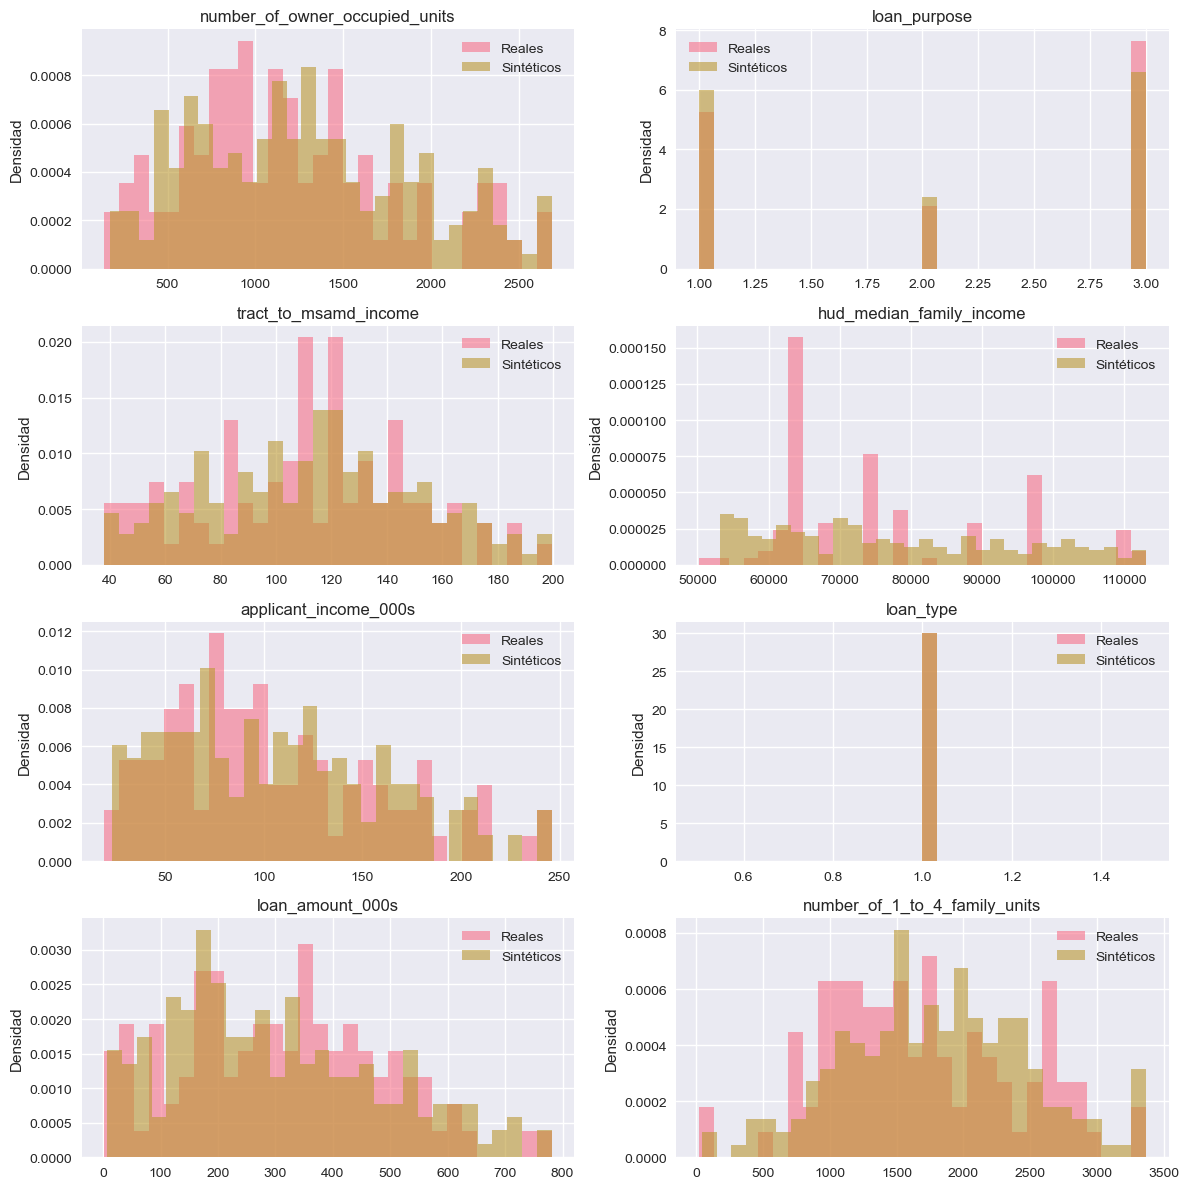

In [8]:
# Visualización comparativa - Distribuciones
if len(numeric_cols) > 0:
    print("📈 COMPARACIÓN DE DISTRIBUCIONES")
    print("="*50)
    
    n_cols = 2  # 2 columnas para comparación lado a lado
    n_rows = (len(numeric_cols) + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3*n_rows))
    if n_rows == 1:
        axes = [axes] if len(numeric_cols) == 1 else axes
    else:
        axes = axes.flatten()
    
    for i, col in enumerate(numeric_cols):
        if i < len(axes):
            # Histogramas superpuestos
            axes[i].hist(df_real[col], bins=30, alpha=0.6, label='Reales', density=True)
            axes[i].hist(df_synthetic[col], bins=30, alpha=0.6, label='Sintéticos', density=True)
            axes[i].set_title(f'{col}')
            axes[i].legend()
            axes[i].set_ylabel('Densidad')
    
    # Ocultar axes vacíos
    for i in range(len(numeric_cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

📦 BOX PLOTS COMPARATIVOS


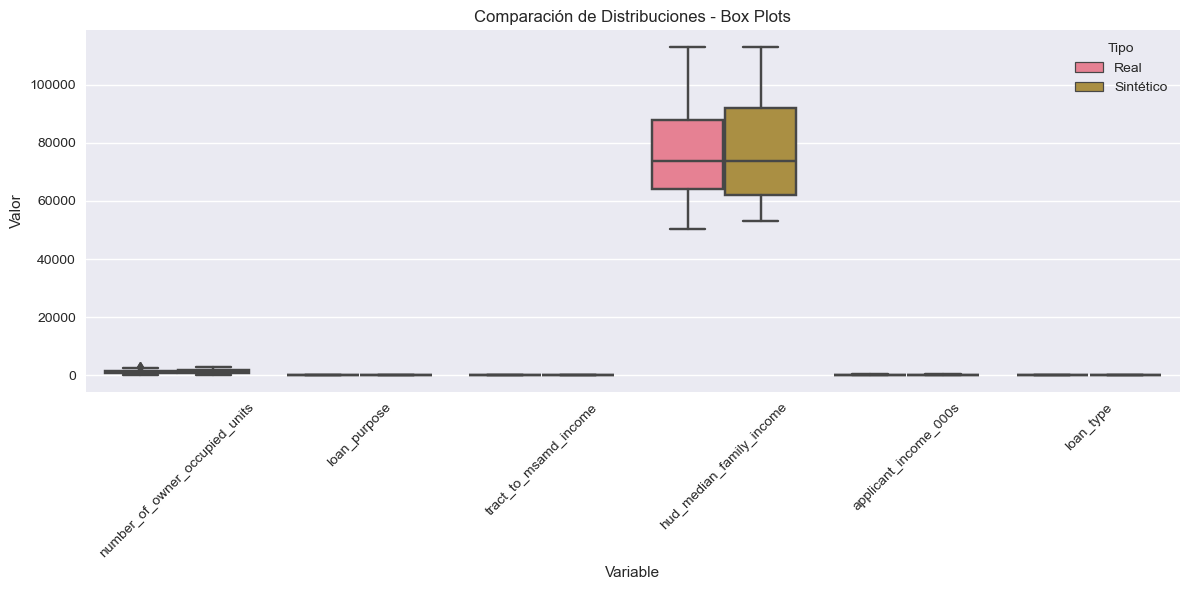

In [9]:
# Box plots comparativos
if len(numeric_cols) > 0:
    print("📦 BOX PLOTS COMPARATIVOS")
    print("="*50)
    
    # Preparar datos para box plots
    comparison_data = []
    for col in numeric_cols[:6]:  # Máximo 6 variables
        real_data = df_real[col].dropna()
        synthetic_data = df_synthetic[col].dropna()
        
        comparison_data.extend([
            {'Variable': col, 'Valor': val, 'Tipo': 'Real'} for val in real_data
        ])
        comparison_data.extend([
            {'Variable': col, 'Valor': val, 'Tipo': 'Sintético'} for val in synthetic_data
        ])
    
    if comparison_data:
        comp_df = pd.DataFrame(comparison_data)
        
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=comp_df, x='Variable', y='Valor', hue='Tipo')
        plt.title('Comparación de Distribuciones - Box Plots')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [10]:
# Tests estadísticos
if len(numeric_cols) > 0:
    print("🔬 TESTS ESTADÍSTICOS")
    print("="*50)
    
    statistical_tests = []
    
    for col in numeric_cols:
        real_data = df_real[col].dropna()
        synthetic_data = df_synthetic[col].dropna()
        
        # Test de Kolmogorov-Smirnov (distribuciones)
        ks_stat, ks_pvalue = stats.ks_2samp(real_data, synthetic_data)
        
        # Test t de Student (medias)
        t_stat, t_pvalue = stats.ttest_ind(real_data, synthetic_data)
        
        # Test de Levene (varianzas)
        levene_stat, levene_pvalue = stats.levene(real_data, synthetic_data)
        
        statistical_tests.append({
            'Variable': col,
            'KS_pvalue': ks_pvalue,
            'KS_similar': 'Sí' if ks_pvalue > 0.05 else 'No',
            'T_test_pvalue': t_pvalue,
            'Medias_similares': 'Sí' if t_pvalue > 0.05 else 'No',
            'Levene_pvalue': levene_pvalue,
            'Varianzas_similares': 'Sí' if levene_pvalue > 0.05 else 'No'
        })
    
    tests_df = pd.DataFrame(statistical_tests)
    display(tests_df.round(4))
    
    print("\n💡 Interpretación:")
    print("- KS_similar: ¿Las distribuciones son similares? (p > 0.05)")
    print("- Medias_similares: ¿Las medias son similares? (p > 0.05)")
    print("- Varianzas_similares: ¿Las varianzas son similares? (p > 0.05)")

🔬 TESTS ESTADÍSTICOS


,Variable,KS_pvalue,KS_similar,T_test_pvalue,Medias_similares,Levene_pvalue,Varianzas_similares
0,number_of_owner_occupied_units,0.3336,Sí,0.2222,Sí,0.5009,Sí
1,loan_purpose,0.8933,Sí,0.2867,Sí,1.0000,Sí
2,tract_to_msamd_income,0.8933,Sí,0.5251,Sí,0.6046,Sí
3,hud_median_family_income,0.0119,No,0.4336,Sí,0.0458,No
4,applicant_income_000s,0.6431,Sí,0.8222,Sí,0.6627,Sí
5,loan_type,1.0000,Sí,NaN,No,NaN,No
6,loan_amount_000s,0.6431,Sí,0.6926,Sí,0.5641,Sí
7,number_of_1_to_4_family_units,0.1710,Sí,0.2224,Sí,0.7980,Sí



💡 Interpretación:
- KS_similar: ¿Las distribuciones son similares? (p > 0.05)
- Medias_similares: ¿Las medias son similares? (p > 0.05)
- Varianzas_similares: ¿Las varianzas son similares? (p > 0.05)


🔗 COMPARACIÓN DE CORRELACIONES


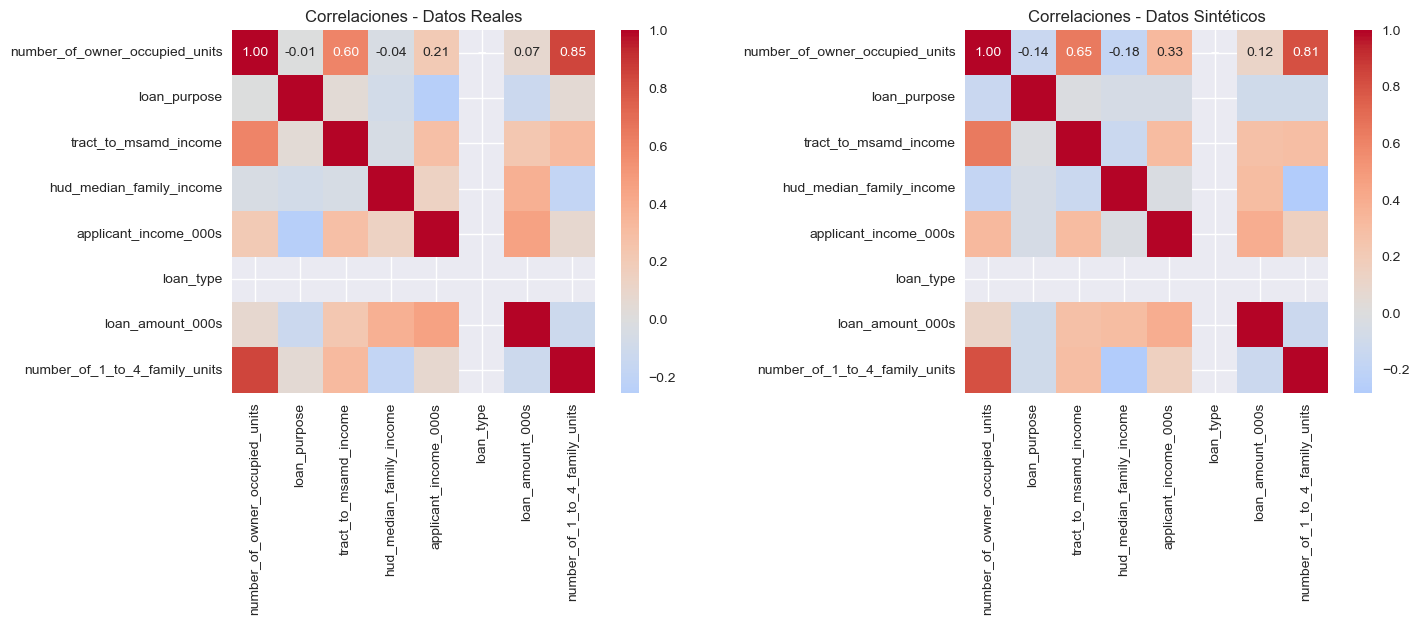


📊 Diferencia promedio en correlaciones: nan


In [11]:
# Análisis de correlaciones
if len(numeric_cols) > 1:
    print("🔗 COMPARACIÓN DE CORRELACIONES")
    print("="*50)
    
    # Calcular matrices de correlación
    corr_real = df_real[numeric_cols].corr()
    corr_synthetic = df_synthetic[numeric_cols].corr()
    
    # Visualización lado a lado
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    sns.heatmap(corr_real, annot=True, cmap='coolwarm', center=0, 
                ax=ax1, fmt='.2f', square=True)
    ax1.set_title('Correlaciones - Datos Reales')
    
    sns.heatmap(corr_synthetic, annot=True, cmap='coolwarm', center=0, 
                ax=ax2, fmt='.2f', square=True)
    ax2.set_title('Correlaciones - Datos Sintéticos')
    
    plt.tight_layout()
    plt.show()
    
    # Diferencia en correlaciones
    corr_diff = abs(corr_real - corr_synthetic)
    print(f"\n📊 Diferencia promedio en correlaciones: {corr_diff.values[np.triu_indices_from(corr_diff, k=1)].mean():.3f}")


In [12]:
# Análisis de variables categóricas
if len(categorical_cols) > 0:
    print("📂 COMPARACIÓN DE VARIABLES CATEGÓRICAS")
    print("="*50)
    
    categorical_comparison = []
    
    for col in categorical_cols:
        real_counts = df_real[col].value_counts(normalize=True).sort_index()
        synthetic_counts = df_synthetic[col].value_counts(normalize=True).sort_index()
        
        # Encontrar categorías comunes
        common_categories = set(real_counts.index) & set(synthetic_counts.index)
        
        if len(common_categories) > 0:
            # Chi-cuadrado test si es posible
            try:
                real_freq = df_real[col].value_counts()
                synthetic_freq = df_synthetic[col].value_counts()
                
                # Alinear las frecuencias
                all_categories = set(real_freq.index) | set(synthetic_freq.index)
                real_aligned = [real_freq.get(cat, 0) for cat in all_categories]
                synthetic_aligned = [synthetic_freq.get(cat, 0) for cat in all_categories]
                
                chi2, chi2_pvalue = stats.chisquare(synthetic_aligned, real_aligned)
                
                categorical_comparison.append({
                    'Variable': col,
                    'Categorías_reales': df_real[col].nunique(),
                    'Categorías_sintéticas': df_synthetic[col].nunique(),
                    'Categorías_comunes': len(common_categories),
                    'Chi2_pvalue': chi2_pvalue,
                    'Distribución_similar': 'Sí' if chi2_pvalue > 0.05 else 'No'
                })
            except:
                categorical_comparison.append({
                    'Variable': col,
                    'Categorías_reales': df_real[col].nunique(),
                    'Categorías_sintéticas': df_synthetic[col].nunique(),
                    'Categorías_comunes': len(common_categories),
                    'Chi2_pvalue': 'N/A',
                    'Distribución_similar': 'N/A'
                })
    
    if categorical_comparison:
        cat_df = pd.DataFrame(categorical_comparison)
        display(cat_df)

📂 COMPARACIÓN DE VARIABLES CATEGÓRICAS


,Variable,Categorías_reales,Categorías_sintéticas,Categorías_comunes,Chi2_pvalue,Distribución_similar
0,respondent_id,62,52,52,N/A,N/A
1,state_abbr,4,58,4,N/A,N/A


In [13]:
# Resumen final y puntuación de similitud
print("🎯 RESUMEN FINAL DE SIMILITUD")
print("="*50)

# Calcular puntuación de similitud
similarity_scores = []

if len(numeric_cols) > 0:
    # Similitud en distribuciones (KS test)
    ks_similar = sum([1 for _, row in tests_df.iterrows() if row['KS_similar'] == 'Sí'])
    ks_score = ks_similar / len(numeric_cols) * 100
    similarity_scores.append(('Distribuciones similares', ks_score))
    
    # Similitud en medias
    medias_similar = sum([1 for _, row in tests_df.iterrows() if row['Medias_similares'] == 'Sí'])
    medias_score = medias_similar / len(numeric_cols) * 100
    similarity_scores.append(('Medias similares', medias_score))
    
    # Similitud en varianzas
    var_similar = sum([1 for _, row in tests_df.iterrows() if row['Varianzas_similares'] == 'Sí'])
    var_score = var_similar / len(numeric_cols) * 100
    similarity_scores.append(('Varianzas similares', var_score))

if len(categorical_cols) > 0 and 'categorical_comparison' in locals():
    # Similitud en categóricas
    cat_similar = sum([1 for row in categorical_comparison if row['Distribución_similar'] == 'Sí'])
    cat_score = cat_similar / len(categorical_cols) * 100 if len(categorical_cols) > 0 else 0
    similarity_scores.append(('Variables categóricas similares', cat_score))

# Mostrar puntuaciones
for metric, score in similarity_scores:
    print(f"✅ {metric}: {score:.1f}%")

if similarity_scores:
    overall_score = np.mean([score for _, score in similarity_scores])
    print(f"\n🏆 PUNTUACIÓN GENERAL DE SIMILITUD: {overall_score:.1f}%")
    
    if overall_score >= 80:
        print("🎉 ¡Excelente! Los datos sintéticos son muy similares a los reales")
    elif overall_score >= 60:
        print("👍 Bueno. Los datos sintéticos son bastante similares a los reales")
    elif overall_score >= 40:
        print("⚠️ Regular. Los datos sintéticos tienen algunas diferencias significativas")
    else:
        print("❌ Los datos sintéticos son muy diferentes a los reales")

print(f"\n📊 Variables analizadas: {len(numeric_cols)} numéricas, {len(categorical_cols)} categóricas")
print("🔬 Tests realizados: Kolmogorov-Smirnov, t-test, Levene, Chi-cuadrado")

🎯 RESUMEN FINAL DE SIMILITUD
✅ Distribuciones similares: 87.5%
✅ Medias similares: 87.5%
✅ Varianzas similares: 75.0%
✅ Variables categóricas similares: 0.0%

🏆 PUNTUACIÓN GENERAL DE SIMILITUD: 62.5%
👍 Bueno. Los datos sintéticos son bastante similares a los reales

📊 Variables analizadas: 8 numéricas, 2 categóricas
🔬 Tests realizados: Kolmogorov-Smirnov, t-test, Levene, Chi-cuadrado
